In [1]:
import matplotlib.pyplot as plt
import json
import pandas as pd
from collections import Counter
from lingua import LanguageDetectorBuilder, Language
from tqdm.auto import tqdm
import random
import numpy as np

/home/jovyan/conda-envs/pythonenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
f = open("devgpt/20231012_233628_pr_sharings.json")
data = json.loads(f.read())
f.close()

In [3]:
urls = []

In [4]:
def generate_documents(data):
    conversation_id = 0
    first_prompts = []
    first_answers = []
    chat_id = 0
    for entry in data["Sources"]:
        for sharedLink in entry["ChatgptSharing"]:
            if sharedLink.get("Conversations"):
                chat_id+=1
                conversation_id = 0
                for conversation in sharedLink["Conversations"]:
                    first_prompts.append({"chat_id" : chat_id, "round_id" : conversation_id, "prompt" : conversation["Prompt"]})
                    first_answers.append({"answer" : conversation["Answer"]})
                    urls.append({"Mentioned_URL" : sharedLink.get("Mention").get("MentionedURL")})
                    conversation_id+=1
    df = pd.DataFrame(first_prompts).join(pd.DataFrame(first_answers)).reset_index(drop=True)
    df = df.join(pd.DataFrame(urls))
    return df

In [5]:
df = generate_documents(data)
df.head(10)

,chat_id,round_id,prompt,answer,Mentioned_URL
0,1,0,can u be my regex tester,"ChatGPTCertainly, I can help you test regular ...",https://github.com/validatorjs/validator.js/pu...
1,1,1,/^(\+?98[\-\s]?|0)9[0-39]\d[\-\s]?\d{3}[\-\s]?...,ChatGPTIt looks like you've provided a regex p...,https://github.com/validatorjs/validator.js/pu...
2,2,0,Explain the difference between imperative and ...,ChatGPTCertainly! Imperative and declarative p...,https://github.com/magnifiq/js-practice-ventio...
3,3,0,I have this code:\n\nconst characterMap: Chara...,ChatGPTThis issue arises because object proper...,https://github.com/FlorianWoelki/obsidian-symb...
4,4,0,"Hello ChatGPT, do you know if an empty string ...","ChatGPTYes, an empty string is a valid Base64-...",https://github.com/asaskevich/govalidator/pull...
5,5,0,lets say I have a some pydantic code like \n\n...,"ChatGPTYes, if a system allows users to specif...",https://github.com/rom-py/rompy/pull/40#issuec...
6,6,0,Can you interpret this SVG path syntax? <path ...,ChatGPTCertainly. The SVG (Scalable Vector Gra...,https://github.com/whatwg/whatwg.org/pull/427#...
7,6,1,This is supposed to be within a 100x100 viewbo...,ChatGPTTo find the center of the path within a...,https://github.com/whatwg/whatwg.org/pull/427#...
8,7,0,I'm building an app that tracks screentime.\n\...,ChatGPTThe code you have shared splits the eve...,https://github.com/ActivityWatch/aw-webui/pull...
9,7,1,But won't this make a messy list for the user?...,"ChatGPTYes, the method I previously suggested ...",https://github.com/ActivityWatch/aw-webui/pull...


In [6]:
len(df.groupby("chat_id"))

286

In [7]:
len(df)

996

In [8]:
#Detect lang https://github.com/pemistahl/lingua-py
def landetec(df):
    detector = LanguageDetectorBuilder.from_all_spoken_languages().build()
    rt_groups = []

    for name, group in df.groupby("chat_id"):
        counter = 0
        not_english_chats_ids = []
        for index, row in group.iterrows():
            lang = detector.detect_language_of(row["prompt"])
            if lang != Language.ENGLISH:
                counter+=1
    #         if row["prompt"].strip() in sample["Prompt"].tolist():
    #             counter += 1
        #some of the rounds are not in english
        if counter == 0:
            rt_groups.append(group)
    #Filter out chats that are not in english
    df_langfiltered = pd.concat(rt_groups)
    return df_langfiltered

In [9]:
#pr
df_langfiltered = landetec(df)
df_langfiltered.head()

,chat_id,round_id,prompt,answer,Mentioned_URL
2,2,0,Explain the difference between imperative and ...,ChatGPTCertainly! Imperative and declarative p...,https://github.com/magnifiq/js-practice-ventio...
3,3,0,I have this code:\n\nconst characterMap: Chara...,ChatGPTThis issue arises because object proper...,https://github.com/FlorianWoelki/obsidian-symb...
4,4,0,"Hello ChatGPT, do you know if an empty string ...","ChatGPTYes, an empty string is a valid Base64-...",https://github.com/asaskevich/govalidator/pull...
5,5,0,lets say I have a some pydantic code like \n\n...,"ChatGPTYes, if a system allows users to specif...",https://github.com/rom-py/rompy/pull/40#issuec...
6,6,0,Can you interpret this SVG path syntax? <path ...,ChatGPTCertainly. The SVG (Scalable Vector Gra...,https://github.com/whatwg/whatwg.org/pull/427#...


In [10]:
len(df_langfiltered.groupby("chat_id"))

240

In [11]:
len(df_langfiltered)

618

In [12]:
#df_langfiltered
dropped_duplicates_df_langfiltered = df_langfiltered.drop_duplicates(subset='prompt')
len(dropped_duplicates_df_langfiltered)

546

In [13]:
len(dropped_duplicates_df_langfiltered.groupby("chat_id"))

220

In [14]:
size_groups = [len(group) for name, group in dropped_duplicates_df_langfiltered.groupby("chat_id")]

df_size = pd.DataFrame(size_groups)

In [15]:
df_size[0].unique()

array([ 1,  2,  3, 16, 29, 20,  4,  6, 22,  7,  5,  8, 19,  9, 33, 13])

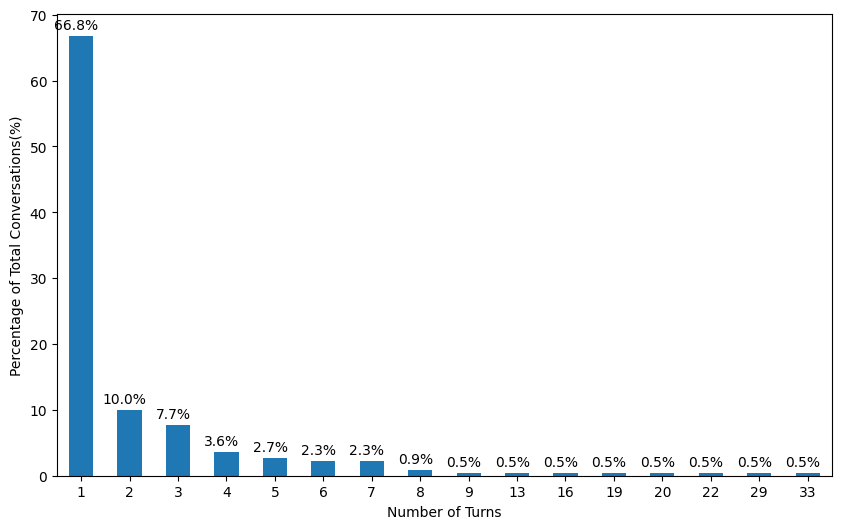

In [16]:
value_counts = df_size[0].value_counts().sort_index()
total_value = df_size[0].count()
percentage = (value_counts/total_value)*100

# Plotting the frequency distribution
plt.figure(figsize=(10, 6))
bars = percentage.plot(kind='bar')

# Annotate with percentage numbers
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 1, f'{bar.get_height():.1f}%', ha='center')

#plt.title('Distribution of Prompt - PR')
plt.xlabel('Number of Turns')
plt.ylabel('Percentage of Total Conversations(%)')
plt.xticks(rotation=0)

# Show the plot
plt.show()

In [17]:
df_size[0].describe(percentiles=[0.25,0.5,0.80, 0.90, 0.95, 0.96, 0.97, 0.98])

count    220.000000
mean       2.481818
std        4.023292
min        1.000000
25%        1.000000
50%        1.000000
80%        3.000000
90%        5.000000
95%        7.000000
96%        8.000000
97%       10.720000
98%       17.860000
max       33.000000
Name: 0, dtype: float64

In [18]:
#RQ1 data
filtered_groups = [group for name, group in dropped_duplicates_df_langfiltered.groupby("chat_id") if len(group) >= 1 and len(group) <= 8]

print(len(filtered_groups))   

212


In [19]:
first_prompts=pd.DataFrame()
for group in filtered_groups:
        first_prompt = group[group["round_id"] == 0]
        first_prompts = pd.concat([first_prompts, first_prompt])
len(first_prompts)

212

In [20]:
first_prompts.head()

,chat_id,round_id,prompt,answer,Mentioned_URL
2,2,0,Explain the difference between imperative and ...,ChatGPTCertainly! Imperative and declarative p...,https://github.com/magnifiq/js-practice-ventio...
3,3,0,I have this code:\n\nconst characterMap: Chara...,ChatGPTThis issue arises because object proper...,https://github.com/FlorianWoelki/obsidian-symb...
4,4,0,"Hello ChatGPT, do you know if an empty string ...","ChatGPTYes, an empty string is a valid Base64-...",https://github.com/asaskevich/govalidator/pull...
5,5,0,lets say I have a some pydantic code like \n\n...,"ChatGPTYes, if a system allows users to specif...",https://github.com/rom-py/rompy/pull/40#issuec...
6,6,0,Can you interpret this SVG path syntax? <path ...,ChatGPTCertainly. The SVG (Scalable Vector Gra...,https://github.com/whatwg/whatwg.org/pull/427#...


In [21]:
first_prompts_rq1 = first_prompts[['chat_id','round_id','prompt','answer']]
first_prompts_rq1.head()

,chat_id,round_id,prompt,answer
2,2,0,Explain the difference between imperative and ...,ChatGPTCertainly! Imperative and declarative p...
3,3,0,I have this code:\n\nconst characterMap: Chara...,ChatGPTThis issue arises because object proper...
4,4,0,"Hello ChatGPT, do you know if an empty string ...","ChatGPTYes, an empty string is a valid Base64-..."
5,5,0,lets say I have a some pydantic code like \n\n...,"ChatGPTYes, if a system allows users to specif..."
6,6,0,Can you interpret this SVG path syntax? <path ...,ChatGPTCertainly. The SVG (Scalable Vector Gra...


In [22]:
first_prompts_rq1.to_excel("rq1_data_pr.xlsx", index=False)
#first_prompts_rq1.to_csv("rq1_data_pr.xlsx", index=False)

In [23]:
#RQ2 data
multiturn = [group for name, group in dropped_duplicates_df_langfiltered.groupby("chat_id") if len(group) >= 2 and len(group) <= 8]
len(multiturn)

65

In [24]:
df_multiturn = pd.concat(multiturn)
len(df_multiturn)

238

In [25]:
df_multiturn.to_excel("rq2_data_pr.xlsx", index=False)
#df_multiturn.to_csv("rq1_data_pr.xlsx", index=False)

In [37]:
#RQ3 data
df_rq1_pr = pd.read_excel('rq1_data_pr.xlsx')
df_rq1_pr

,chat_id,Category,prompt,answer,type
0,264,Conceptual,Why can’t I validate a self signed http tls ce...,ChatGPTWhen you have two servers isolated from...,pr
1,80,Review,\n# TODO: Some issues with the parameters imho...,ChatGPTThe TODO suggests that there's a proble...,pr
2,207,Conceptual,is it bad practice to use v-html in vue?,ChatGPTUsing v-html in Vue.js to insert raw HT...,pr
3,21,Conceptual,"Generally speaking, how would you order the pr...","ChatGPTIn many software systems, there are mul...",pr
4,242,Conceptual,what's the difference between openapi oneOf vs...,"ChatGPTIn OpenAPI, oneOf and anyOf are JSON Sc...",pr
...,...,...,...,...,...
205,35,Human language translation,"convert to arabic\n<string name=""dictionaries""...",ChatGPTHere is the Arabic translation of the g...,pr
206,197,Code generation,laravel redirect with flush message,ChatGPTTo redirect a user to a new page in Lar...,pr
207,199,Issue resolving,I like how I get some of localStorage rendered...,ChatGPTGiven the current architecture of the a...,pr
208,237,How-to,"How to program a GitHub bot that reacts to ""/f...",ChatGPTTo program a GitHub bot that reacts to ...,pr


In [38]:
df_rq1_pr['Mentioned_URL'] = ''
for index, row in df_rq1_pr.iterrows():
    chat_id = row['chat_id']
    matching_url = first_prompts.loc[first_prompts['chat_id'] == chat_id, 'Mentioned_URL']
    df_rq1_pr.at[index, 'Mentioned_URL'] = matching_url.iloc[0]
    
df_rq1_pr

,chat_id,Category,prompt,answer,type,Mentioned_URL
0,264,Conceptual,Why can’t I validate a self signed http tls ce...,ChatGPTWhen you have two servers isolated from...,pr,https://github.com/nickbabcock/OhmGraphite/pul...
1,80,Review,\n# TODO: Some issues with the parameters imho...,ChatGPTThe TODO suggests that there's a proble...,pr,https://github.com/bancaditalia/black-it/pull/...
2,207,Conceptual,is it bad practice to use v-html in vue?,ChatGPTUsing v-html in Vue.js to insert raw HT...,pr,https://github.com/telosnetwork/open-block-exp...
3,21,Conceptual,"Generally speaking, how would you order the pr...","ChatGPTIn many software systems, there are mul...",pr,https://github.com/NixOS/nix/pull/8902
4,242,Conceptual,what's the difference between openapi oneOf vs...,"ChatGPTIn OpenAPI, oneOf and anyOf are JSON Sc...",pr,https://github.com/astahmer/openapi-zod-client...
...,...,...,...,...,...,...
205,35,Human language translation,"convert to arabic\n<string name=""dictionaries""...",ChatGPTHere is the Arabic translation of the g...,pr,https://github.com/open-learning-exchange/mypl...
206,197,Code generation,laravel redirect with flush message,ChatGPTTo redirect a user to a new page in Lar...,pr,https://github.com/Ayahiro-Inatsugu/ph3-websit...
207,199,Issue resolving,I like how I get some of localStorage rendered...,ChatGPTGiven the current architecture of the a...,pr,https://github.com/hoshotakamoto/banzukesurfin...
208,237,How-to,"How to program a GitHub bot that reacts to ""/f...",ChatGPTTo program a GitHub bot that reacts to ...,pr,https://github.com/mdn/content/pull/27070#issu...


In [35]:
len(df_rq1_pr['Mentioned_URL'])

210

In [54]:
from sklearn.model_selection import train_test_split
pr_sample = df_rq1_pr.groupby('Category', group_keys=False).apply(lambda x: x.sample(min(len(x), 100)))
len(pr_sample)

210

In [55]:
pr_class_proportions = df_rq1_pr['Category'].value_counts(normalize=True)

num_samples_pr = 99

pr_sampled = pd.DataFrame()

In [56]:
for label, proportion in pr_class_proportions.items():
    # Calculate the number of samples for this class
    num_samples = int(num_samples_pr * proportion)
    
    # Sample from the original dataset
    samples = df_rq1_pr[df_rq1_pr['Category'] == label].sample(n=num_samples, random_state=42)
    
    # Append to the sampled dataset
    pr_sampled = pd.concat([pr_sampled, samples])
    
print(len(pr_sampled))

90


In [57]:
pr_sample_file_path = 'rq3_pr_sample.xlsx'

pr_sampled.to_excel(pr_sample_file_path, index=False)